### BRIEF:  
- Imputed missing pollutant values using mean and log-transformed `rspm` to reduce skew  
- Engineered temporal features and encoded categorical variables for richer context  
- Trained a tuned Random Forest Regressor on the full feature set  
- Achieved strong performance (R² = 0.7933, MAE ≈ 40.95 µg/m³)  
- Saved the model for deployment in Week 3  

### IMPORT LIBRARIES:

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

import joblib
import sys
import os

sys.path.append(os.path.abspath(".."))
sys.path.append(os.path.abspath("."))


### LOAD DATASET

In [2]:
# Load Dataset
df = pd.read_csv("../data/data.csv", dtype={'stn_code': str}, low_memory=False)

# Preserve original state names for plotting
df['state_raw'] = df['state']


### INITIAL EXPLORATION

In [3]:
# Initial Exploration
df.info()
df.describe()
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 435742 entries, 0 to 435741
Data columns (total 14 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0       stn_code                 291665 non-null  object 
 1   sampling_date                435739 non-null  object 
 2   state                        435742 non-null  object 
 3   location                     435739 non-null  object 
 4   agency                       286261 non-null  object 
 5   type                         430349 non-null  object 
 6   so2                          401096 non-null  float64
 7   no2                          419509 non-null  float64
 8   rspm                         395520 non-null  float64
 9   spm                          198355 non-null  float64
 10  location_monitoring_station  408251 non-null  object 
 11  pm2_5                        9314 non-null    float64
 12  date                         435735 non-null  object 
 13 

    stn_code                   144077
sampling_date                       3
state                               0
location                            3
agency                         149481
type                             5393
so2                             34646
no2                             16233
rspm                            40222
spm                            237387
location_monitoring_station     27491
pm2_5                          426428
date                                7
state_raw                           0
dtype: int64

### DATA CLEANING AND IMPUTATION

In [4]:
# Data Cleaning & Imputation

# Drop columns with excessive missing data
df = df.drop(columns=['pm2_5'], errors='ignore')  # pm2_5 is ~98% missing

# Drop rows missing target variable
df = df.dropna(subset=['spm'])  # spm is your target, so rows missing it must go

# Impute key features using mean (faster than KNN)
df['so2'] = df['so2'].fillna(df['so2'].mean())
df['no2'] = df['no2'].fillna(df['no2'].mean())
df['rspm'] = df['rspm'].fillna(df['rspm'].mean())

# Log transform skewed features to reduce outlier impact
df['rspm'] = np.log1p(df['rspm'])  # Helps linear models handle skewed data

# Optional: Visual check for outliers (can be moved to EDA block if preferred)
# for col in ['so2', 'no2', 'rspm', 'spm']:
#     sns.boxplot(x=df[col])
#     plt.title(f'Boxplot of {col}')
#     plt.show()


In [5]:
# COLUMN CHECK
print("All Columns in DataFrame:")
print(df.columns.tolist())

# PREVIEW state_raw VALUES
print("Preview of state_raw:")
print(df['state_raw'].dropna().unique())


All Columns in DataFrame:
['    stn_code', 'sampling_date', 'state', 'location', 'agency', 'type', 'so2', 'no2', 'rspm', 'spm', 'location_monitoring_station', 'date', 'state_raw']
Preview of state_raw:
['Andhra Pradesh' 'Assam' 'Bihar' 'Chandigarh' 'Chhattisgarh'
 'Dadra & Nagar Haveli' 'Daman & Diu' 'Delhi' 'Goa' 'Gujarat' 'Haryana'
 'Himachal Pradesh' 'Jammu & Kashmir' 'Jharkhand' 'Karnataka' 'Kerala'
 'Madhya Pradesh' 'Maharashtra' 'Manipur' 'Meghalaya' 'Mizoram' 'Nagaland'
 'Odisha' 'Puducherry' 'Punjab' 'Rajasthan' 'Sikkim' 'Tamil Nadu'
 'Uttar Pradesh' 'Uttarakhand' 'Uttaranchal' 'West Bengal']


### Feature Engineering & Encoding

In [6]:
# Define Features and Target

# Convert date column
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Extract temporal features
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year
df['dayofweek'] = df['date'].dt.dayofweek

# Encode categorical features
categorical_cols = ['state', 'location', 'agency', 'type']
existing_cats = [col for col in categorical_cols if col in df.columns]
df = pd.get_dummies(df, columns=existing_cats, drop_first=True)

# Define target and feature set
y = df['spm']
X = df.drop(columns=['spm', '    stn_code', 'location_monitoring_station', 'date', 'state_raw'], errors='ignore')


### FINAL DATA CHECK

In [7]:
# Final Data Check
df.drop(columns=['sampling_date'], errors='ignore', inplace=True)

print("DataFrame Structure After Cleaning:")
df.info()

print("\nStatistical Summary:")
print(df.describe())

print("\nRemaining Missing Values:")
print(df.isnull().sum())


DataFrame Structure After Cleaning:
<class 'pandas.core.frame.DataFrame'>
Index: 198355 entries, 11 to 431457
Columns: 310 entries,     stn_code to type_Sensitive Areas
dtypes: bool(299), datetime64[ns](1), float64(4), int32(3), object(3)
memory usage: 72.5+ MB

Statistical Summary:
                 so2            no2           rspm            spm  \
count  198355.000000  198355.000000  198355.000000  198355.000000   
mean       12.054988      27.182122       4.485171     220.783480   
min         0.000000       0.000000       0.000000       0.000000   
25%         6.000000      15.100000       4.127134     111.000000   
50%        10.100000      23.600000       4.644391     187.000000   
75%        13.800000      33.200000       4.828314     296.000000   
max       273.300000     484.300000       8.749579    3380.000000   
std        10.270038      18.509568       0.665344     151.395457   

                                date          month           year  \
count                   

### Pollutant Distribution

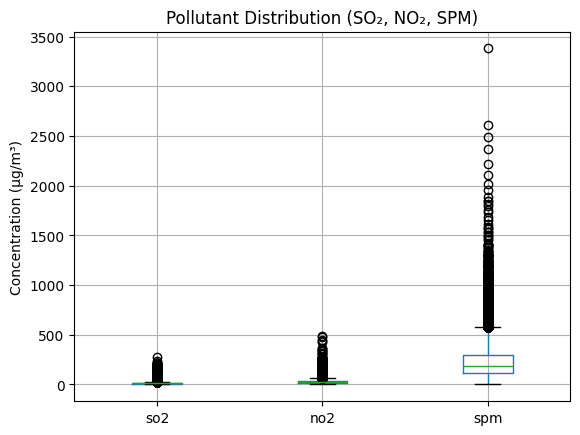

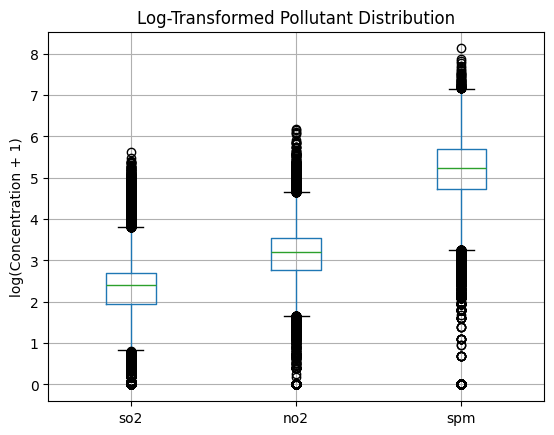

In [8]:
# Distribution of key pollutants
df[['so2', 'no2', 'spm']].boxplot()
plt.title("Pollutant Distribution (SO₂, NO₂, SPM)")
plt.ylabel("Concentration (µg/m³)")
plt.grid(True)
plt.show()

df[['so2', 'no2', 'spm']].apply(np.log1p).boxplot()
plt.title("Log-Transformed Pollutant Distribution")
plt.ylabel("log(Concentration + 1)")
plt.grid(True)
plt.show()


### Average SPM by State

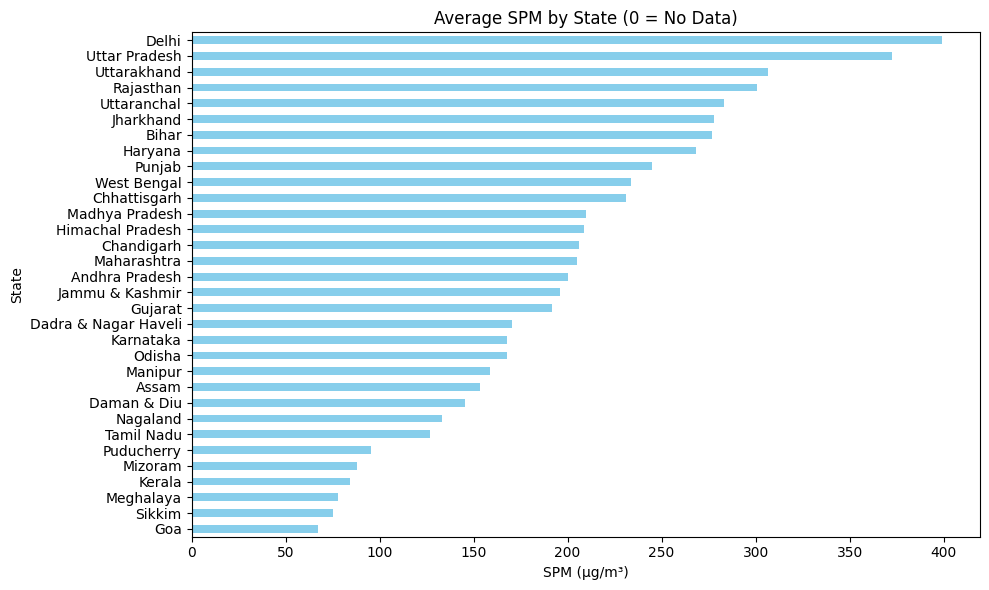

In [9]:
# Visualizing Average SPM by State
if 'state_raw' in df.columns and df['state_raw'].notna().any():
    spm_by_state = df.groupby('state_raw')['spm'].mean().fillna(0)
    spm_by_state.sort_values().plot(kind='barh', figsize=(10,6), color='skyblue')
    plt.title("Average SPM by State (0 = No Data)")
    plt.xlabel("SPM (µg/m³)")
    plt.ylabel("State")
    plt.tight_layout()
    plt.show()
else:
    print("'state_raw' column not found or empty. Skipping state-wise SPM plot.")


### Correlation Heatmap

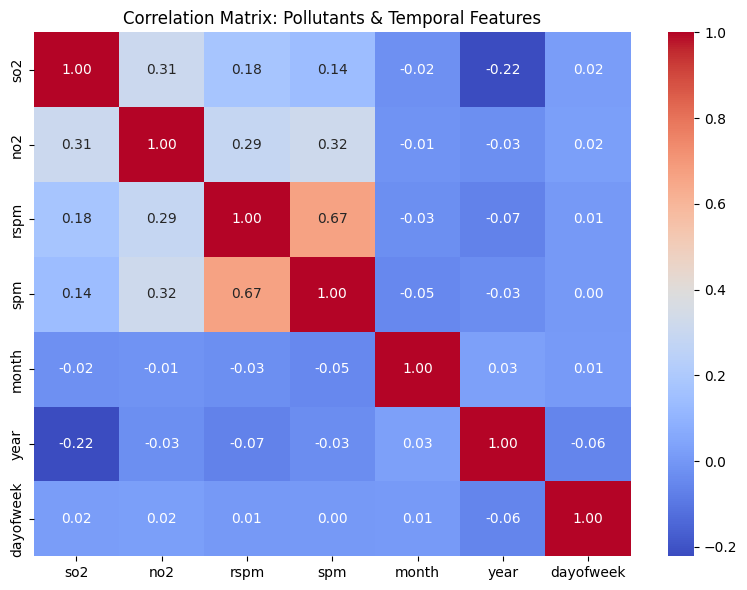

In [10]:
# Correlation Heatmap
corr_features = ['so2', 'no2', 'rspm', 'spm', 'month', 'year', 'dayofweek']
plt.figure(figsize=(8,6))
sns.heatmap(df[corr_features].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix: Pollutants & Temporal Features")
plt.tight_layout()
plt.show()


In [11]:
# Custom parser for 'February - M021990' format
def parse_custom_date(val):
    try:
        month_str, code = val.split(" - ")
        month_num = int(code[1:3])
        year = int(code[3:])
        return pd.Timestamp(year=year, month=month_num, day=1)
    except:
        return pd.NaT


### Time Series Plot

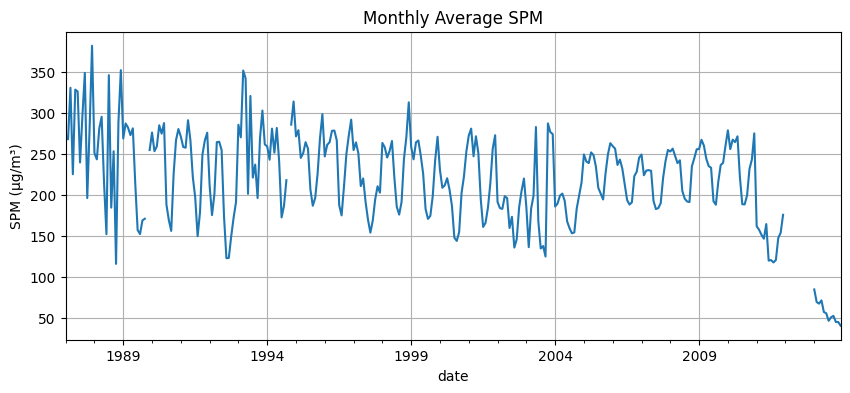

In [12]:
# Time Series Plot using 'date'
df.set_index('date')['spm'].resample('ME').mean().plot(figsize=(10, 4))
plt.title("Monthly Average SPM")
plt.ylabel("SPM (µg/m³)")
plt.grid(True)
plt.show()


### Preprocessing + Model Training

In [13]:
# Preprocessing + Model Training (Enhanced)

# Use full feature set excluding non-predictive columns
X = df.drop(columns=[
    'spm',                      # target
    '    stn_code',             # redundant
    'location_monitoring_station',  # sparse
    'date',                     # already decomposed
    'state_raw'                 # for plotting only
], errors='ignore')

y = df['spm']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train optimized Random Forest model (no scaling needed)
model = RandomForestRegressor(
    n_estimators=200,
    max_depth=20,
    min_samples_split=10,
    random_state=42,
    n_jobs=-1
)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)


# Evaluation Metrics
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

error_percent = (mae / y_test.mean()) * 100
tolerance = 0.1 * y_test.mean()
accuracy = np.mean(np.abs(y_pred - y_test) < tolerance) * 100

print(f"R² Score           : {r2:.4f}")
print(f"Mean Squared Error : {mse:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")
print(f"Error Percentage   : {error_percent:.2f}%")
print(f"Custom Accuracy    : {accuracy:.2f}%")


R² Score           : 0.7933
Mean Squared Error : 4788.45
Mean Absolute Error: 40.95
Error Percentage   : 18.44%
Custom Accuracy    : 47.95%


### Prediction Diagnostics

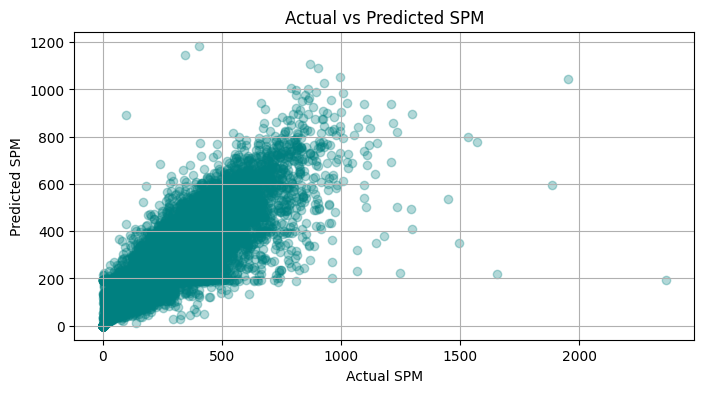

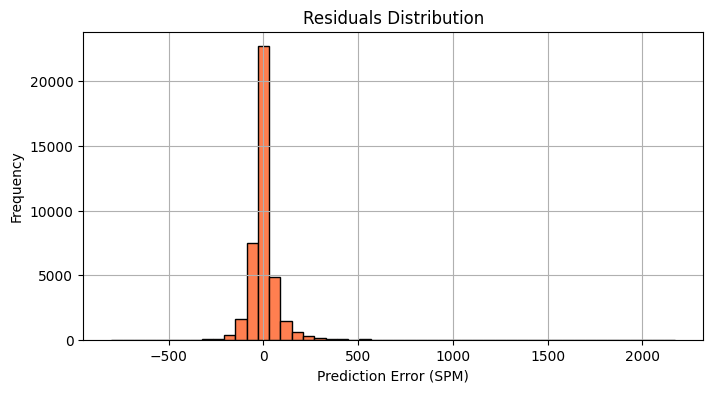

In [14]:
# Actual vs Predicted Scatter Plot
plt.figure(figsize=(8, 4))
plt.scatter(y_test, y_pred, alpha=0.3, color='teal')
plt.xlabel("Actual SPM")
plt.ylabel("Predicted SPM")
plt.title("Actual vs Predicted SPM")
plt.grid(True)
plt.show()

# Residuals Histogram
residuals = y_test - y_pred
plt.figure(figsize=(8, 4))
plt.hist(residuals, bins=50, color='coral', edgecolor='black')
plt.title("Residuals Distribution")
plt.xlabel("Prediction Error (SPM)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


### Prediction vs Actual Plot

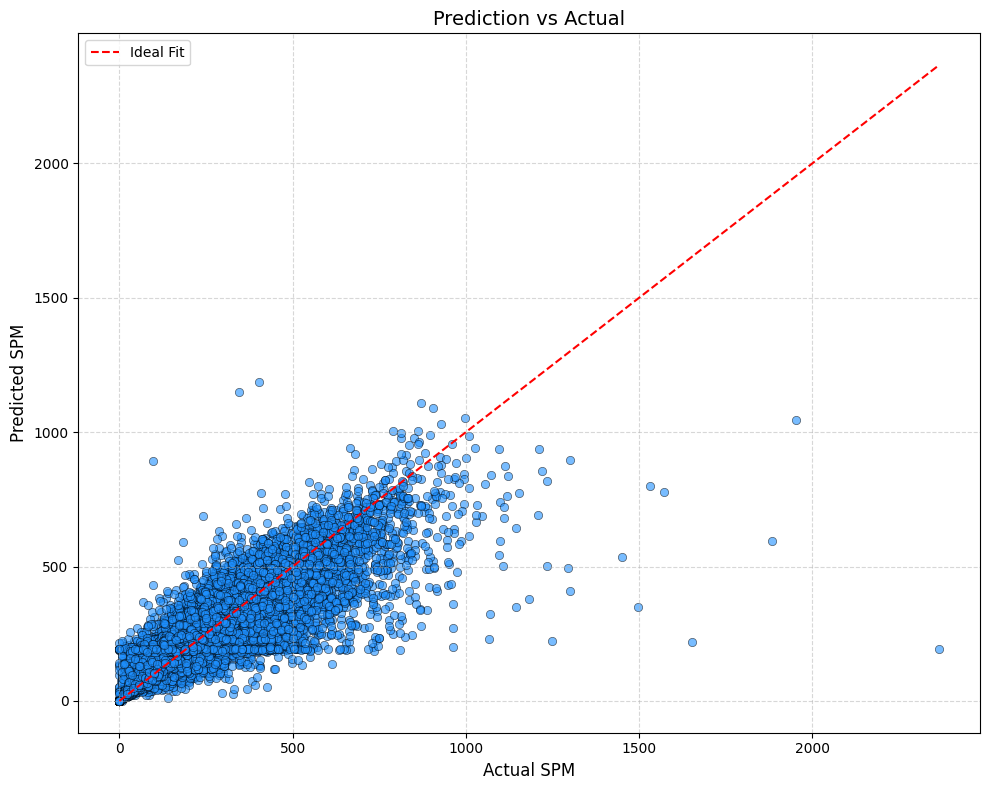

In [15]:
# Prediction vs Actual Plot
plt.figure(figsize=(10,8))
plt.scatter(y_test, y_pred, alpha=0.6, color='dodgerblue', edgecolors='k', linewidths=0.5)
plt.xlabel("Actual SPM", fontsize=12)
plt.ylabel("Predicted SPM", fontsize=12)
plt.title("Prediction vs Actual", fontsize=14)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Ideal Fit')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


### Save Model and Scaler

In [16]:
# Save model and scaler
joblib.dump(model, "../models/random_forest_model.pkl")

print("Model and scaler saved successfully.")


Model and scaler saved successfully.


In [17]:
# Define path to metrics file
metrics_path = "../model_metrics.md"

# Prepare metrics content
metrics_content = f"""
## Week 2 Model Metrics

- **R² Score**: {r2:.4f}
- **Mean Absolute Error (MAE)**: {mae:.4f}
- **Mean Squared Error (MSE)**: {mse:.4f}
"""

# Write to model_metrics.md
with open(metrics_path, "w") as f:
    f.write(metrics_content)

print("Model metrics written to model_metrics.md")


Model metrics written to model_metrics.md


### Preprocessing Summary  
- Dropped rows with missing `spm` values and columns with excessive nulls  
- Imputed missing pollutant values (`so2`, `no2`, `rspm`) using mean  
- Extracted temporal features and applied one-hot encoding to categorical columns  

### Model Summary  
- Trained a tuned Random Forest Regressor on full feature set  
- Achieved R² of **0.7933** and MAE of **40.95 µg/m³**  
- Saved model for deployment in Week 3  


### Next Steps
- Linear regression model trained and evaluated
- Performance is weak — consider using Random Forest or adding categorical features
- Visuals confirm prediction spread and bias
- Model and scaler saved for reproducibility
